# Final Project

# INGV - Volcanic Eruption Prediction

**Your name:** Carter Figgins

**A-Number:** A02243978



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob


## 1. Read in Data

In [2]:
# get data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Adding feature functions

In [3]:
def getNewColNames(name):
  return{
         'sensor_1' : 'sensor_1_'+ name,
         'sensor_2' : 'sensor_2_'+ name,
         'sensor_3' : 'sensor_3_'+ name,
         'sensor_4' : 'sensor_4_'+ name,
         'sensor_5' : 'sensor_5_'+ name, 
         'sensor_6' : 'sensor_6_'+ name, 
         'sensor_7' : 'sensor_7_'+ name, 
         'sensor_8' : 'sensor_8_'+ name, 
         'sensor_9' : 'sensor_9_'+ name, 
         'sensor_10' : 'sensor_10_'+ name,
        }

In [4]:
def create_features(data):
  mean = pd.DataFrame(data.mean()).transpose()
  sum = pd.DataFrame(data.sum()).transpose()
  std = pd.DataFrame(data.std()).transpose()
  var = pd.DataFrame(data.var()).transpose()
  max = pd.DataFrame(data.max()).transpose()
  min = pd.DataFrame(data.min()).transpose()
  skew = pd.DataFrame(data.skew()).transpose()
  mad = pd.DataFrame(data.mad()).transpose()
  kurtosis = pd.DataFrame(data.kurtosis()).transpose()

  newData = pd.concat([mean, sum, std, var, max, min, skew, mad, kurtosis], axis=1, sort=False)

  return newData

- Read in data from files

In [6]:


path = "./drive/MyDrive"
train = pd.read_csv(path + "/train.csv")

size = len(train)

count = 0
p = 0

print("size:", size)

train_sensors = np.array([ [0 for _ in range(90)] for _ in range(size)])
train_times = np.array([0 for _ in range(size)])
for _, row in train.iterrows():
  count += 1
  s_id = str(row['segment_id'])
  data = pd.read_csv(path + "/train/" + s_id + ".csv")
  data = data.fillna(0)
  data = create_features(data)
  data = data[:size].values.astype(float)


  train_sensors[count -1] = data
  train_times[count -1] = row['time_to_eruption']

  if count % (size//10) == 0:
    p+=10
    print(str(p)+'%')

  #  Use smaller data for tests (Change size to get smaller data)
  if count == size:
    break




size: 4431
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


## 2. Define the Model and Hyper Prameters

In [7]:
class Net (nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    self.linear = nn.Sequential(
        nn.Linear(90, 75),
        nn.ReLU(True),
        nn.Linear(75, 50),
        nn.ReLU(True),
        nn.Linear(50, 25),
        nn.ReLU(True),
        nn.Linear(25, 1)
    )


  def forward(self, x):
    x = self.linear(x)
    return x

#Hyper-parameters
batch_size = 128
epochs = 500
learning_rate = 0.0005

## 3. Train Model

- combinding features and labels together in class

In [8]:
# make class to combind data and lables
from torch.utils.data import Dataset, DataLoader
class Valcano_Dataset(Dataset):
    def __init__(self, train_features, train_labels):
        super().__init__()
        self.train_features = train_features
        self.train_labels = train_labels

    def __len__(self):
        return len(self.train_features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.train_features[idx], self.train_labels[idx])

train_data = Valcano_Dataset(train_sensors, train_times)
train_iter = DataLoader(train_data, batch_size, shuffle=True)

- Making Optimizer and Loss Function

In [9]:

# Optimizer and loss function
lossFunction = nn.MSELoss()
net = Net()
net.to('cuda')
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

- Train Modal on data

In [10]:
train_loss = []

count = 0
p=0
for epoch in range(epochs):
  batch_loss = []
  for data, labels in train_iter:
    labels = labels.reshape(-1, 1)
    y_hat = net(data.cuda().float())
    loss = lossFunction(y_hat, labels.cuda().float())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batch_loss.append(loss.item())
  count += 1
  if count % (len(range(epochs))//10) == 0:
    p+=10
    print(p, '%')
  
  train_loss.append(np.mean(batch_loss))



10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %


## View Results

In [11]:
from matplotlib import pyplot as plt
from IPython import display

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """Plot x and log(y)."""

    def set_figsize(figsize=(3.5, 2.5)):
        """Set matplotlib figure size."""
        display.set_matplotlib_formats('svg')
        plt.rcParams['figure.figsize'] = figsize

    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

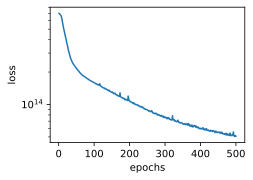

In [12]:
semilogy(range(1, epochs + 1), train_loss, 'epochs', 'loss')

In [13]:
import random
# read in all test files 
path = "./drive/MyDrive"
test_files = glob.glob(path + "/train/*.csv")
count = 0
p=0
size = len(test_files)
offby = np.array([0 for _ in range(size)])
guess_array = np.array([0 for _ in range(size)])
real_array = np.array([0 for _ in range(size)])
print(len(test_files))
random.shuffle(test_files)

for path in test_files:
  id = path.split('/')[-1].split('.')[0]
  data = pd.read_csv(path)
  data = data.fillna(0)
  data = create_features(data)
  data = data[:].values.astype(float)
  data = torch.from_numpy(data)
  y_hat = net(data.cuda().float())
  guess = torch.mean(y_hat)
  real = train.loc[train['segment_id'] == int(id)]['segment_id'].to_string(index=False)
  real = float(real)
  item = guess.item() *100
  real_array[count] = real
  guess_array[count] = item
  if real > item:
    offby[count] = (real - item)
  else:
    offby[count] = (item - real)
  count += 1
  if count % (size//10) == 0:
    p+=10
    print(str(p)+'%')
  if count == size:
    break
offby.sort()
np.mean(offby)

4431
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


1450825610.7490408

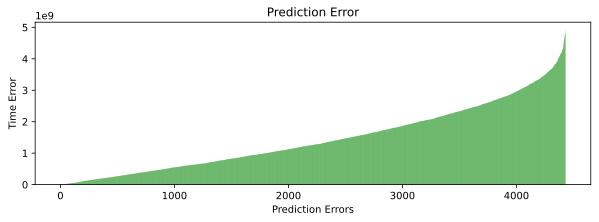

Max: 4917394832   Min 96572   Avg: 1450825610.7490408


In [20]:
# GRAPH OFF BY

nums = [i for i in range(len(offby))]
graphSize = len(offby)

plt.bar(nums[:graphSize], offby[:graphSize],color='g')
plt.rcParams["figure.figsize"] = (20,6)
plt.ylabel('Time Error')
plt.xlabel('Prediction Errors')
plt.title('Prediction Error')
plt.show()
print('Max:', offby[-1], '  Min', offby[0], '  Avg:', np.mean(offby))

fig, ax = plt.subplots()
ax.bar(nums, guess_array[:50], color='y', label="Prediction")
ax.bar(nums, real_array[:50], color = 'b', label="Correct Time")
ax.set_ylabel('Eruption Time (min)')
ax.set_xlabel('Predictions')
ax.legend()
plt.show()


Submit to Kaggle

In [ ]:
# read in all test files 
path = "./drive/MyDrive"
test_files = glob.glob(path + "/test/*.csv")
subForm = {'segment_id':[], 'time_to_eruption':[]}

segmentId = np.array([0 for _ in test_files])
timeToEruption = np.array([0 for _ in test_files])

print("arrays ready")
count = 0
p = 0
for path in test_files:
  id = path.split('/')[-1].split('.')[0]
  data = pd.read_csv(path)
  data = data.fillna(0)
  data = create_features(data)
  data = data[:].values.astype(float)
  data = torch.from_numpy(data)
  guess = net(data.cuda().float())
  # guess = net(data.float())
  guess = torch.mean(guess)
  segmentId[count] = id
  timeToEruption[count] = guess
  count +=1
  if count % (len(test_files)//10) == 0:
    p+=10
    print(str(p)+'%')

subForm['segment_id'] = segmentId
subForm['time_to_eruption'] = timeToEruption

submission = pd.DataFrame(subForm, columns = ['segment_id', 'time_to_eruption'])
print(submission)
submission.to_csv(r'./submission.csv', index =False, header=True )  

arrays ready
10%
20%
30%
